In [146]:
import numpy as np
import pandas as pd
import sklearn
from pandas import DataFrame
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import time
from statsmodels.graphics.tsaplots import plot_acf
#from bayes_opt import BayesianOptimization

Here we will put all the function at the same time, then after we will execute one after another our main

In [147]:
# Function to explore the data
def explore_data(df):
    print(df.describe())
    print(df.isnull().sum())
    print(df.dtypes)

# Function for feature engineering
def engineer_features(df):
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek # this is a panda function that give the nmber of the date (weeknd are 5, 6) Monday is 0
    df['Month'] = df['Date'].dt.month
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
    return df


# Function for data cleaning
def clean_data(df):
    df.fillna(df.mean(), inplace=True)  # Example: fill missing values with the mean
    # Add other data cleaning steps here
    return df

In [148]:
# Function for data transformation
def transform_data1(df, target_column_name):
    # Drop the target column and any non-numeric columns
    # attention there are categorical data that shouldn't be scaled, so w have exclude them
    X = df.select_dtypes(include=[np.number]).drop([target_column_name], axis=1)
    y = df[target_column_name]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Convert the scaled features back to a DataFrame
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
    return X_scaled_df, y


# Assuming 'Date' column or any datetime type columns are correctly excluded from X_to_scale
def transform_data(df, target_column_name, exclude_from_scaling=None):
    if exclude_from_scaling is None:
        exclude_from_scaling = []

    # Ensure 'Date' column is also excluded if still present
    df_numeric = df.select_dtypes(include=[np.number, 'bool'])  # 'bool' included if you have boolean types
    X = df_numeric.drop([target_column_name] + exclude_from_scaling, errors='ignore', axis=1)
    y = df[target_column_name]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns) # you may ask why: After scaling, X_scaled is a NumPy array
    # without the column names, because the scaling operation returns a NumPy array. This line converts X_scaled back
    # into a pandas

    # Re-include the excluded features without scaling
    X_excluded = df[exclude_from_scaling].reset_index(drop=True)
    X_final = pd.concat([X_scaled_df, X_excluded], axis=1)
    print("Make sure transformation is well done:")
    print(X_final)
    return X_final, y


In [149]:
# Function to split the data
def split_data(X, y, test_size=0.2, random_state=203):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [150]:
###
    # we start with SVR, but it will works with others models
def train_model(X_train, y_train, technique, params):
    """
    Trains an SVR model based on the specified technique and parameters.

    :param X_train: Training feature dataset.
    :param y_train: Training target dataset.
    :param technique: Specifies the technique to use.
                      "SVR default" for default parameters, "SVR" for custom parameters.
    :param params: Dictionary of parameters for the SVR model.
    :return: Trained SVR model.
    """
    if technique == "SVR default":
        model = SVR()
    elif technique == "SVR":
        model = SVR(**params)
    else:
        raise ValueError("Unsupported technique specified.")

    model.fit(X_train, y_train)
    return model

In [151]:
def evaluate_model(model, X_test, y_test):
    """

    :type model: this is a trained model, and it's coming from the returned value of train_model
    """
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    # Print the evaluation metrics
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R^2 Score: {r2}")

    return predictions, mse, mae, rmse, r2

In [152]:
def perform_grid_search(X_train, y_train):  # i don't like it. it only works with SVR, but we will leave it to later
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf']
    }
    grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

In [153]:
def perform_random_search(X_train, y_train, model, param_dist, n_iter=100):
    random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                       n_iter=n_iter, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    return random_search.best_params_, random_search.best_score_

In [154]:
def tune_hyperparameters(X_train, y_train, model, param_grid):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_, grid_search.best_score_

In [155]:
def plotting(predictions, y_test):
    plt.figure(figsize=(14, 7))
    plt.plot(predictions, label='Predicted', alpha=0.7)
    plt.plot(y_test.values, label='Actual', alpha=0.5)  # Ensure y_test is a series, so we access .values
    plt.title('Actual vs. Predicted Values Over Time')
    plt.xlabel('Time/Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

bissmillah let's run

In [156]:
path_bureau= r'H:\perso\thesis\data\germany_2023.xlsx'
path_home = '/Users/mohamedabdellahi/Desktop/Trust the process/1- M203/master thesis/data/germany-Main.xlsx'
path= path_home
target_column_name= 'Day Ahead Auction'
df = pd.read_excel(path, skiprows=[1])
explore_data(df)

                                Date  Cross border electricity trading  \
count                           8760                       8760.000000   
mean   2023-07-02 12:05:40.684931840                       1339.493233   
min              2023-01-01 00:00:00                     -19226.890000   
25%              2023-04-02 06:45:00                      -3548.647500   
50%              2023-07-02 12:30:00                       1590.575000   
75%              2023-10-01 18:15:00                       6687.985000   
max              2023-12-31 23:00:00                      17081.870000   
std                              NaN                       6958.835067   

           Nuclear  Non-Renewable     Renewable          Load  \
count  2519.000000    8760.000000   8760.000000   8760.000000   
mean   2671.735395   18984.858203  29720.436555  52246.634053   
min     271.760000    5911.920000   7956.630000  30908.880000   
25%    2410.400000   11938.817500  18863.142500  44765.217500   
50%    2

In [157]:
df= engineer_features(df)
print(df.head())

                 Date  Cross border electricity trading  Nuclear  \
0 2023-01-01 00:00:00                         -12557.67  2459.17   
1 2023-01-01 01:00:00                         -15382.58  2458.60   
2 2023-01-01 02:00:00                         -16357.50  2459.64   
3 2023-01-01 03:00:00                         -14005.92  2460.48   
4 2023-01-01 04:00:00                         -14544.00  2460.80   

   Non-Renewable  Renewable      Load  Day Ahead Auction  \
0        9146.69   38384.86  38536.48              -5.17   
1        8925.66   39415.38  37935.26              -1.07   
2        8902.44   39610.49  37103.11              -1.47   
3        8901.05   37023.62  36139.27              -5.08   
4        8863.19   36499.65  35711.44              -4.49   

   CO2 Emission Allowances, Auction DE  CO2 Emission Allowances, Auction EU  \
0                                83.41                                 84.1   
1                                83.41                                 8

In [158]:
df = clean_data(df)
            #centrer et reduire
X_scaled, y = transform_data(df, target_column_name, ['Hour', 'DayOfWeek', 'Month', 'IsWeekend'])
            #splitting the data
X_train, X_test, y_train, y_test = split_data(X_scaled, y)

Make sure transformation is well done:
      Cross border electricity trading   Nuclear  Non-Renewable  Renewable  \
0                            -1.997167 -1.256802      -1.094008   0.683074   
1                            -2.403136 -1.260173      -1.118586   0.764317   
2                            -2.543242 -1.254023      -1.121168   0.779699   
3                            -2.205296 -1.249057      -1.121323   0.575759   
4                            -2.282623 -1.247165      -1.125533   0.534451   
...                                ...       ...            ...        ...   
8755                         -1.211422  0.000000      -1.115145   1.063649   
8756                         -1.378633  0.000000      -1.149018   1.120290   
8757                         -1.440207  0.000000      -1.149018   1.110235   
8758                         -1.609622  0.000000      -1.155415   1.094560   
8759                         -1.835855  0.000000      -1.155152   1.084700   

          Load  CO2 Emis

In [159]:
param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.001, 0.01, 0.1, 1],
        'epsilon': [0.1, 0.2, 0.5, 0.3]
}


In [160]:
# Specify distributions rather than a list of options
param_dist = { # for random research
    'C': reciprocal(0.1, 1000),
    'gamma': expon(scale=1.0),
    'epsilon': [0.01, 0.1, 0.2, 0.5, 1]
}

In [161]:
#######------------------- Model training and evaluation
# Hyperparameter tuning
start_timeCalibration= time.time()
best_params, best_score = tune_hyperparameters(X_train, y_train, SVR(), param_grid)
end_timeCalibration = time.time()
calibration_time = end_timeCalibration - start_timeCalibration

In [162]:
print(f"Calibration time for Grid Research: {calibration_time} seconds")

Calibration time for Grid Research: 88.3411955833435 seconds


In [163]:
start_timeCalibrationRnd = time.time()
best_paramsRandom, best_scoreRandom = perform_random_search(X_train, y_train, SVR(), param_dist, n_iter=100)
end_timeCalibrationRnd = time.time()
calibration_timeRnd = end_timeCalibrationRnd - start_timeCalibrationRnd
print(f"Calibration time for Random search: {calibration_timeRnd} seconds")

Calibration time for Random search: 297.6867980957031 seconds


In [164]:
start_time_training= time.time()
model= train_model(X_train, y_train,"SVR", best_params)   #here we train the model
model2 = train_model(X_train, y_train, "SVR", best_paramsRandom)
end_time_training = time.time()
training_time = end_time_training - start_time_training
print(f"Training time: {training_time} seconds")

Training time: 33.1393940448761 seconds


In [165]:
#predictions, mse, mae, rmse, r2= evaluate_model(model, X_test, y_test)
evaluate_model(model, X_test, y_test)

Mean Squared Error: 154.4031826949386
Mean Absolute Error: 7.9366774791600445
Root Mean Squared Error: 12.425907721166233
R^2 Score: 0.9290971036443263


(array([  5.22725404,  76.21386354,  93.20328146, ..., 146.9096476 ,
        180.36738145,  -2.79088637]),
 154.4031826949386,
 7.9366774791600445,
 12.425907721166233,
 0.9290971036443263)

In [166]:
print(f"model with random search")
evaluate_model(model2, X_test, y_test)

model with random search
Mean Squared Error: 106.50629526902362
Mean Absolute Error: 6.621409437083286
Root Mean Squared Error: 10.32018872254881
R^2 Score: 0.9510916505548567


(array([  3.75722902,  77.24239807,  87.30269547, ..., 148.66751776,
        187.45619562,  -3.82135568]),
 106.50629526902362,
 6.621409437083286,
 10.32018872254881,
 0.9510916505548567)

In [167]:
predictions, mse, mae, rmse, r2= evaluate_model(model, X_test, y_test)

Mean Squared Error: 154.4031826949386
Mean Absolute Error: 7.9366774791600445
Root Mean Squared Error: 12.425907721166233
R^2 Score: 0.9290971036443263


In [168]:
predictions1, mse1, mae1, rmse1, r2= evaluate_model(model2, X_test, y_test)

Mean Squared Error: 106.50629526902362
Mean Absolute Error: 6.621409437083286
Root Mean Squared Error: 10.32018872254881
R^2 Score: 0.9510916505548567


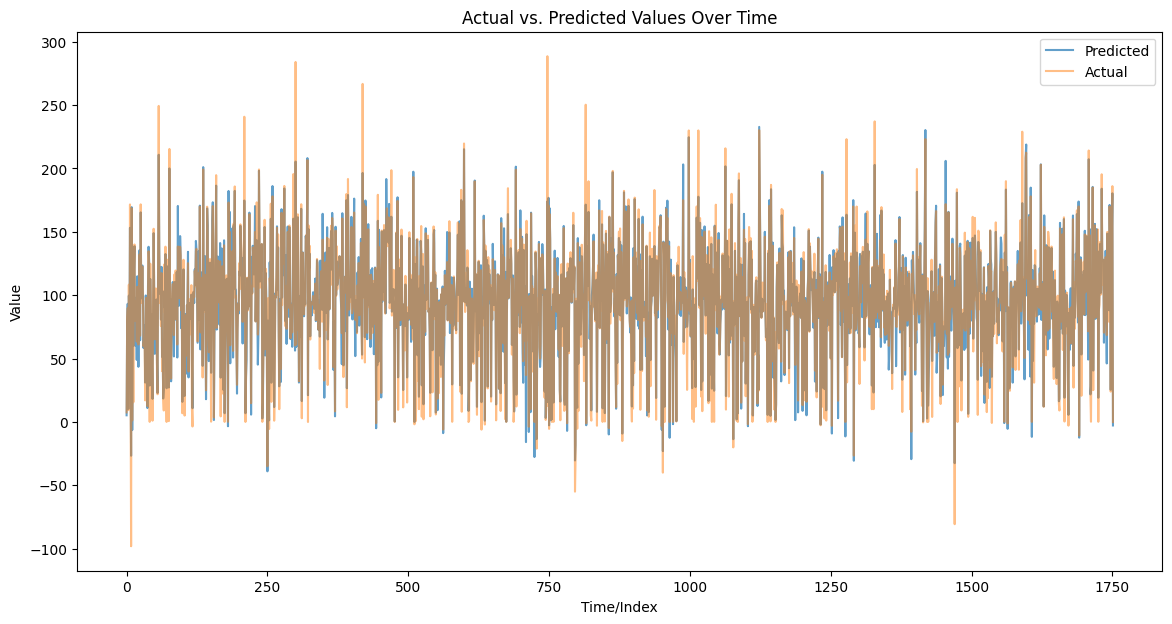

In [169]:
# Graphical presenetation
plotting(predictions, y_test)

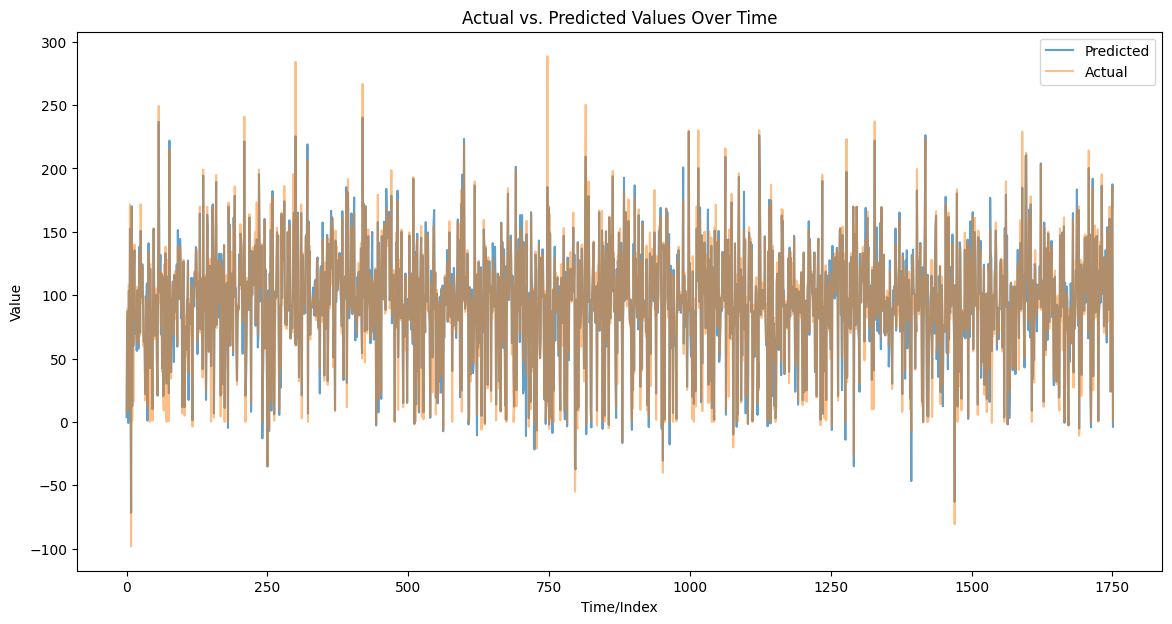

In [170]:
plotting(predictions1, y_test)

In the subsequent phase of our investigation, we aim to enhance the forecasting capabilities of the Support Vector Machine (SVM) model for electricity price prediction by explicitly incorporating domain-specific knowledge about temporal patterns, such as seasonality, and market behaviors like backwardation and contango. This endeavor will involve a multifaceted approach focusing on advanced feature engineering, the exploration of hybrid modeling techniques, and the utilization of custom preprocessing strategies. The goal is to enable the SVM model to more accurately capture and predict the complex dynamics of hourly electricity prices.

Advanced Feature Engineering
Recognizing the pivotal role of temporal patterns in influencing electricity prices, we will undertake comprehensive feature engineering to embed these insights into the model. This will include:

Time-Based Features: Introduction of features that reflect the time of day, day of the week, month, and year to capture inherent seasonal and cyclic patterns in electricity prices.
Lag Features: Incorporation of lagged price values as features to account for the impact of past prices on future values, thereby capturing temporal dependencies.
Rolling Window Statistics: Implementation of rolling window calculations (e.g., mean, standard deviation) over past prices to represent short-term trends and variability.
Fourier Transforms: Application of Fourier transforms to model and encode seasonality as features, aiming to capture and leverage oscillatory market patterns.
Hybrid Modeling Techniques
Acknowledging the limitations of traditional SVM in capturing sequential dependencies and complex seasonal trends, we will explore hybrid models that synergize SVM with time series analysis techniques. This exploration will consider:

Combination with ARIMA/Seasonal Decomposition: Utilization of ARIMA models or seasonal decomposition to extract and remove seasonality and trends from the data, using the residuals as input to the SVM model to focus on capturing the non-linear and non-seasonal dynamics.
Custom Data Preprocessing
To further tailor the model to the nuances of electricity market data, we will implement custom data preprocessing strategies:

Segmented Normalization: Application of normalization or standardization techniques within specific time segments to address the unique scale and distribution of prices at different times, reflecting market phenomena like backwardation or contango.
Incorporation of Domain Knowledge
We will leverage domain knowledge to introduce external features indicative of market behaviors and regulatory factors affecting electricity prices:

Market Behavior Indicators: Development of binary indicators or features to signal periods known for specific price behaviors due to external factors such as market opening/closing times or peak demand periods.
This comprehensive approach, grounded in domain expertise and sophisticated analytical techniques, is designed to significantly elevate the predictive performance of our SVM-based forecasting model. By integrating detailed temporal patterns and market behaviors into the modeling process, we aim to achieve a nuanced understanding and prediction of hourly electricity prices. The insights and methodologies developed through this phase will be meticulously documented and analyzed, contributing to the body of knowledge on applying machine learning techniques in energy market forecasting.

This segment of the research encapsulates our commitment to pushing the boundaries of predictive modeling within the energy sector, harnessing the power of machine learning to generate actionable insights with high accuracy and reliability.

In [171]:
def add_lag_features(df, lags=[1, 24, 168]):  # 1 hour, 24 hours (1 day), 168 hours (1 week)
    for lag in lags:
        df[f'lag_{lag}_hours'] = df['Day Ahead Auction'].shift(lag)
    return df

Rolling window statistics can capture trends and volatility over time. Here, we'll add rolling means and standard deviations over various windows.

In [172]:
def add_rolling_window_features(df, windows=[24, 168]):  # 24 hours, 168 hours
    for window in windows:
        df[f'rolling_mean_{window}'] = df['Day Ahead Auction'].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['Day Ahead Auction'].rolling(window=window).std()
    return df

Fourier transforms can help model complex seasonal patterns. Here's how you might start with a basic implementation, focusing on capturing daily and weekly seasonality.

In [173]:
import numpy as np
def add_fourier_features(df, periods=[24, 168]):  # Daily and weekly seasonality
    for period in periods:
        df[f'sin_{period}'] = np.sin(df['Hour'] * (2 * np.pi / period))
        df[f'cos_{period}'] = np.cos(df['Hour'] * (2 * np.pi / period))
    return df

Introduce binary indicators for specific hours known to have distinct pricing behaviors due to market activities.

In [174]:
def add_market_behavior_indicators(df):
    # Example: Indicator for peak hours (e.g., 17:00 to 21:00)
    df['peak_hours'] = df['Hour'].apply(lambda x: 1 if 17 <= x <= 21 else 0)
    # Add more indicators based on domain knowledge
    return df

In [175]:
# let's apply
df = engineer_features(df)  # Your initial feature engineering
df = add_lag_features(df)
df = add_rolling_window_features(df)
df = add_fourier_features(df)
df = add_market_behavior_indicators(df)
df= df.iloc[168:].reset_index(drop=True)


now we will retrain the model and see if there is better accuracy

In [176]:
path_export = '/Users/mohamedabdellahi/Desktop/Trust the process/1- M203/master thesis/data/test.xlsx'
df.to_excel(path_export, engine='openpyxl', index=False)


In [177]:
df2= df.copy()
explore_data(df2)

                                Date  Cross border electricity trading  \
count                           8592                       8592.000000   
mean   2023-07-06 00:06:22.541899520                       1498.192408   
min              2023-01-08 00:00:00                     -19226.890000   
25%              2023-04-07 12:45:00                      -3370.082500   
50%              2023-07-06 00:30:00                       1717.760000   
75%              2023-10-03 12:15:00                       6791.657500   
max              2023-12-31 23:00:00                      17081.870000   
std                              NaN                       6880.195694   

           Nuclear  Non-Renewable     Renewable          Load  \
count  8592.000000    8592.000000   8592.000000   8592.000000   
mean   2676.317308   19023.079280  29581.170357  52256.943762   
min     271.760000    5911.920000   7956.630000  30908.880000   
25%    2671.735395   11923.787500  18728.702500  44770.795000   
50%    2

In [201]:
def autocorrel(target_column, lag, title="Autocorrelation Function"):
    plot_acf(target_column, lags= lag)  # Adjust the number of lags as needed
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title(title)
    plt.show()

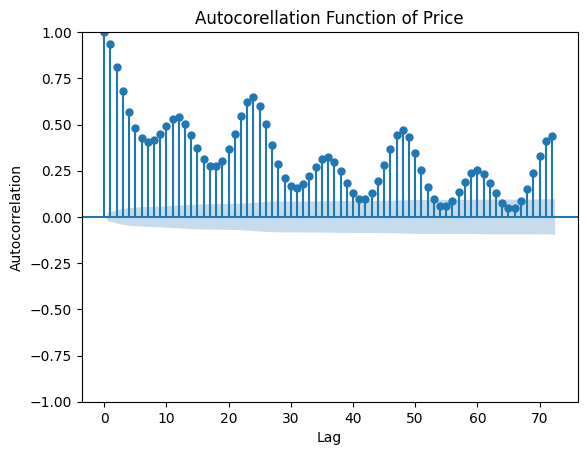

In [203]:
autocorrel(df["Day Ahead Auction"], 72, "Autocorellation Function of Price")